In [45]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import curve_fit

In [46]:
dat_files_list = glob.glob(os.path.join('2-GaAs-bulk', '*.dat'))

In [47]:
dict_of_all_dfs = {}
for file_name in dat_files_list:
    df = pd.read_csv(file_name, sep="	")
    file_name_sep = file_name.split('__')
    df_name = file_name_sep[0].split('\\')[1] + '_' + file_name_sep[-1][0:-4]
    dict_of_all_dfs[df_name] = df

In [48]:
print(dict_of_all_dfs.keys())

dict_keys(['20230928-154719_ref', '20230928-155156_ref', '20230928-155856_3mmHole+0.5mmGaAs', '20230928-155938_3mmHole+0.5mmGaAs'])


# Constants

In [49]:
c = 3e8 # meters per second
d = 0.5e-3 # meters
N = dict_of_all_dfs['20230928-154719_ref']['X'].shape[0]
print(f"c = {c:.1e} m/s \nN = {N}")

c = 3.0e+08 m/s 
N = 3001


# Transforming the position column

The position column `pos` are positions from the delay line. Since the light speed is constant, we can transform the data to moment in time and set to a relative moment. I'll set $t=0$ the moment whose X is maximum for **reference data** (without sample). The times are calculated as:

$$
t_n = 2(x_n - x_0) / c,
$$

Where $x_n$ is the n-th position of the delay line and c is the speed of light. The factor 2 is because the displacement of the delay line doubles the beam path.

In [50]:
id_max_X = dict_of_all_dfs['20230928-154719_ref']['X'].idxmax()
for df in dict_of_all_dfs.values():
    df['time_moment'] = (df['pos']-df['pos'][id_max_X])*2e-3/c

In [51]:
time_step = dict_of_all_dfs['20230928-154719_ref']['time_moment'][1] - dict_of_all_dfs['20230928-154719_ref']['time_moment'][0]
print(f"\ntime step = {time_step*1e12:1.3f} ps")


time step = 0.033 ps


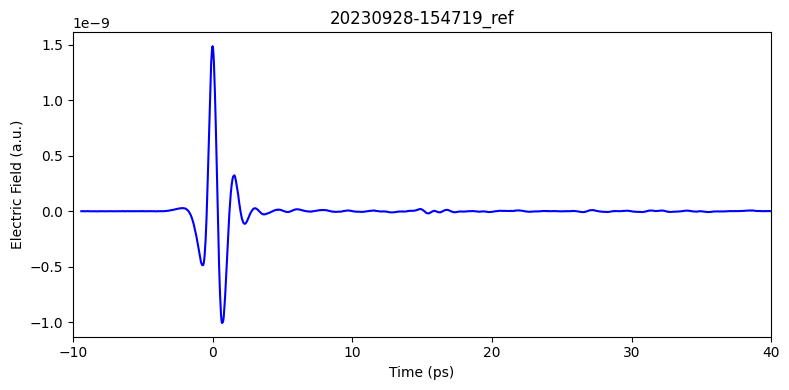

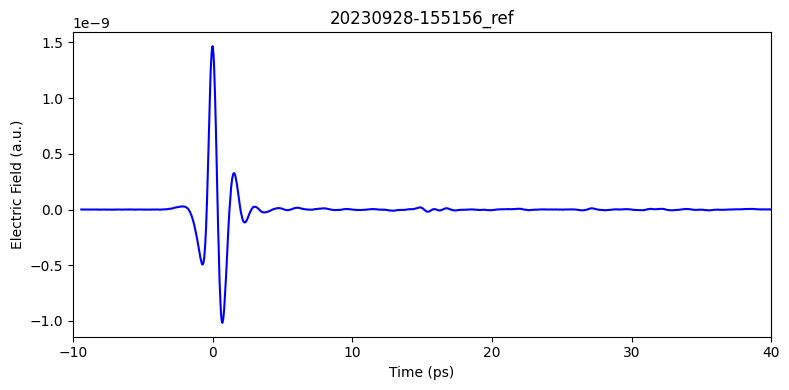

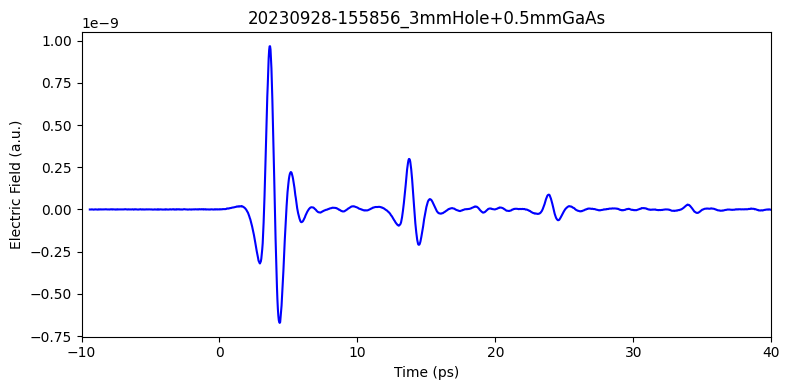

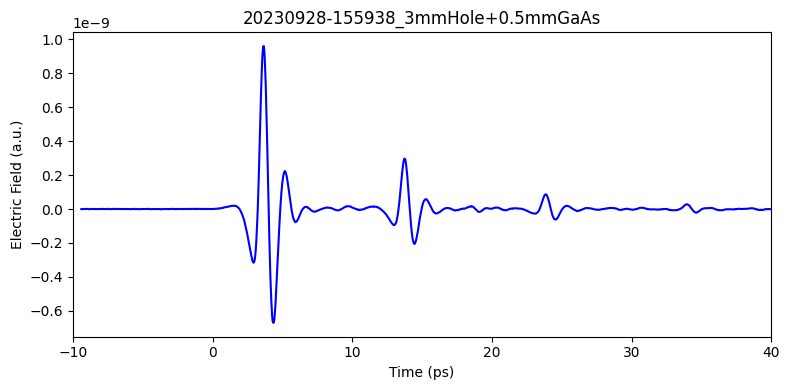

In [52]:
for df_name, df in dict_of_all_dfs.items():
    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.plot(df['time_moment']*1e12, df['X'],'b')
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('Electric Field (a.u.)')
    ax.set_title(df_name)
    ax.set_xlim((-10,40))
    plt.show()

In [53]:
id_maxE_GaAs = dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'].idxmax()
id_maxE_GaAs_reflection = dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'][500:800].idxmax()
time_delay = dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['time_moment'][id_maxE_GaAs]*1e12
time_delay_reflection = dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['time_moment'][id_maxE_GaAs_reflection]*1e12 - time_delay
print(f'Time delay (GaAs - ref) = {time_delay:1.2f} ps \nTime delay (GaAs Transmitted - GaAs reflected) = {time_delay_reflection:1.2f} ps')

Time delay (GaAs - ref) = 3.67 ps 
Time delay (GaAs Transmitted - GaAs reflected) = 10.07 ps


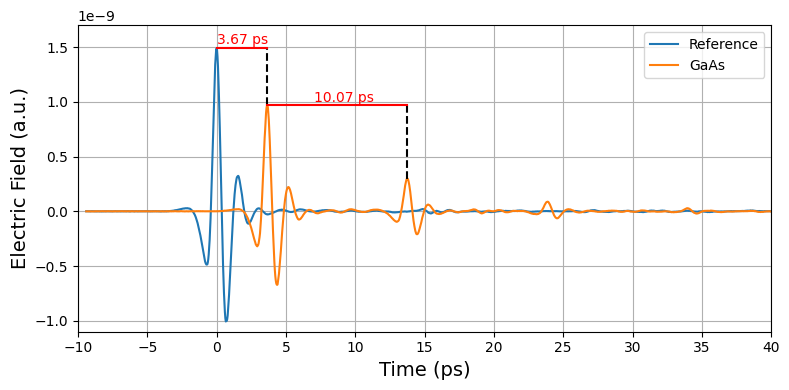

In [54]:
id = 0
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
for df_name, df in dict_of_all_dfs.items():
    id+=1
    if id%2==0:
        continue
    ax.plot(df['time_moment']*1e12, df['X'])
    ax.set_xlabel('Time (ps)', fontsize=14)
    ax.set_ylabel('Electric Field (a.u.)', fontsize=14)
    # ax.set_title(df_name)
# ax.plot([0, 0], [-1e-9, dict_of_all_dfs['20230928-154719_ref']['X'][id_max_X]], 'k')
ax.plot([time_delay, time_delay], [dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'][id_maxE_GaAs], dict_of_all_dfs['20230928-154719_ref']['X'][id_max_X]], '--k')
ax.plot([0, time_delay], [dict_of_all_dfs['20230928-154719_ref']['X'][id_max_X], dict_of_all_dfs['20230928-154719_ref']['X'][id_max_X]], 'r')
ax.plot([time_delay_reflection + time_delay, time_delay_reflection + time_delay], [dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'][id_maxE_GaAs], dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'][id_maxE_GaAs_reflection]], '--k')
ax.plot([time_delay, time_delay_reflection+time_delay], [dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'][id_maxE_GaAs],dict_of_all_dfs['20230928-155856_3mmHole+0.5mmGaAs']['X'][id_maxE_GaAs]], 'r')
ax.annotate(f'{time_delay:1.2f} ps', xy=(0.05, 1.53e-9), xytext=(0.05, 1.53e-9), color='red')
ax.annotate(f'{time_delay_reflection:1.2f} ps', xy=(7, 1e-9), xytext=(7, 1e-9), color='red')
ax.set_xlim((-10,40))
ax.set_xticks(np.arange(-10,45,5))
ax.set_ylim((-1.1e-9, 1.7e-9))
plt.legend(['Reference', 'GaAs'])
plt.grid()
plt.show()

# GaAs Bulk

Here we're using a sample with nominal thickness of 0.5 mm. The sample is thick enough for the reflections don't overlap the main pulse, as we can see in the figure above. The refraction index of GaAs in terahertz range of frequency is almost constant (low dispersivity). I'm saying this because we can estimate the refractive index only using the delay between the main pulse and it's first reflection, considering that it's the time the wave went back and forth in the bulk (path of $2d$ length):

$$
\Delta t_R = \frac{2d}{c}n \hspace{10pt}\rightarrow\hspace{10pt} n = \frac{c \Delta t_R}{2d}.
$$

A different approach is to use the peak delay between the reference pulse and the main pulse through the sample:

$$
\Delta t_T = \frac{d}{v_{GaAs}} - \frac{d}{v_air} = \frac{d}{c}(n-1) \hspace{10pt}\rightarrow\hspace{10pt} n = 1 + \frac{c\Delta t_T}{d}.

In [55]:
n_reflection = c * time_delay_reflection / (2 * d)*1e-12
n_transmission = 1 + c * time_delay / d*1e-12

print(f"n using the reflected pulse = {n_reflection:1.2f} \nn using the transmitted wave = {n_transmission:1.2f}")

n using the reflected pulse = 3.02 
n using the transmitted wave = 3.20


It's quite a good approximation (ref values are ~ 3.6). But we can calculate considering dispersion, using the truncated pulse. This means that we gonna perform the same calculations we did for water, considering it a thick sample ($nd \approx 1.5mm$), but truncating the data before the first reflection and using the zero padding technique to have a bigger resolution in frequency.

# Truncation and zero padding

In [56]:
Nzeros = 1500
dict_of_all_dfs_zero_padding = {}
id=0
for file_name in dat_files_list:
    id+=1
    df = pd.read_csv(file_name, sep="	")
    file_name_sep = file_name.split('__')
    df_name = file_name_sep[0].split('\\')[1] + '_' + file_name_sep[-1][0:-4]+'_zero_padding'
    df_truncated = df[:500]
    final_pos = df_truncated['pos'].iloc[-1]
    pos_step = df_truncated['pos'][1] - df_truncated['pos'][0]
    zero_padding_df2add = pd.DataFrame({'pos': np.linspace(final_pos+pos_step, final_pos+pos_step*Nzeros, Nzeros), 'X': np.zeros(Nzeros)})
    df_zp = pd.concat([df_truncated, zero_padding_df2add], ignore_index=True)
    dict_of_all_dfs_zero_padding[df_name] = df_zp

In [57]:
dict_of_all_dfs_zero_padding_fft = {key_name+"_fft": np.conj(fft(df['X'])) for key_name, df in dict_of_all_dfs_zero_padding.items()}

In [58]:
N_zero_padding = dict_of_all_dfs_zero_padding['20230928-154719_ref_zero_padding'].shape[0]
freqs = fftfreq(N_zero_padding, time_step)[:N_zero_padding//2]

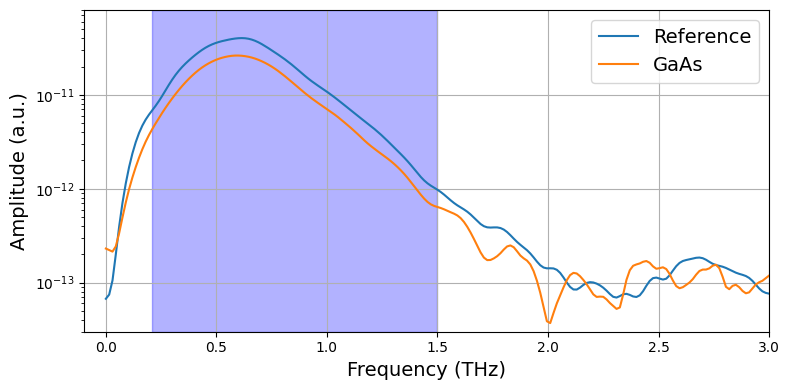

In [78]:
figure, ax = plt.subplots(figsize=(8,4), tight_layout=True)
id = 0
max_freq_id = len(freqs[freqs<3e12])
low_freq_id = len(freqs[freqs<.2e12])
for df_name, df in dict_of_all_dfs_zero_padding_fft.items():
    id+=1
    if id%2==0:
        continue
    y = 2.0/N_zero_padding * np.abs(df[:N_zero_padding])
    ax.semilogy(freqs[:max_freq_id]*1e-12, y[:max_freq_id])
ax.set_xlabel('Frequency (THz)', fontsize=14)
ax.set_ylabel('Amplitude (a.u.)', fontsize=14)
ax.legend(['Reference', 'GaAs'], fontsize=14)
ax.fill_betweenx([3e-14, 8e-11], freqs[low_freq_id]*1e-12, freqs[max_freq_id//2]*1e-12, alpha=0.3, color='blue')
ax.set_ylim((3e-14, 8e-11))
ax.set_xlim((-.1, 3))
ax.grid()
plt.show()

In [60]:
T = dict_of_all_dfs_zero_padding_fft['20230928-155856_3mmHole+0.5mmGaAs_zero_padding_fft'] / dict_of_all_dfs_zero_padding_fft['20230928-154719_ref_zero_padding_fft']

In [61]:
phase = np.angle(T)
phase_unwrapped = np.unwrap(np.angle(T))
n = 1 + c / (2 * np.pi * freqs[1:] * d) * phase_unwrapped[1:N_zero_padding//2]
kappa = - c / (2 * np.pi * freqs[1:] * d) * np.log((n + 1)**2 / (4 * n) * np.abs(T[1:N_zero_padding//2]))
alpha = 4 * np.pi * kappa * freqs[1:] / c

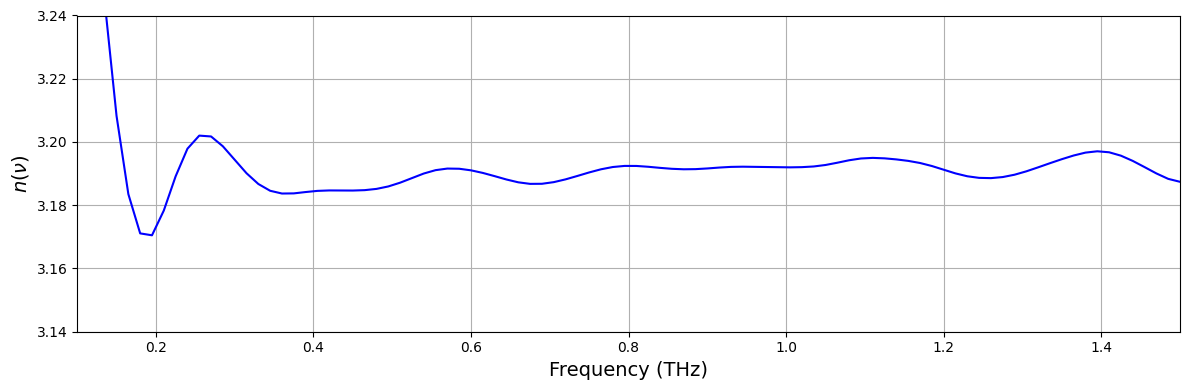

In [62]:
figure, ax = plt.subplots(figsize=(12,4), tight_layout=True)
ax.plot(freqs[1:max_freq_id]*1e-12, n[1:max_freq_id], 'b')
ax.set_xlabel('Frequency (THz)', fontsize=14)
ax.set_ylabel(r'$n(\nu)$', fontsize=14)
ax.set_xlim((0.1,1.5))
ax.set_ylim((3.19-0.05,3.19+0.05))
ax.grid()
plt.show()

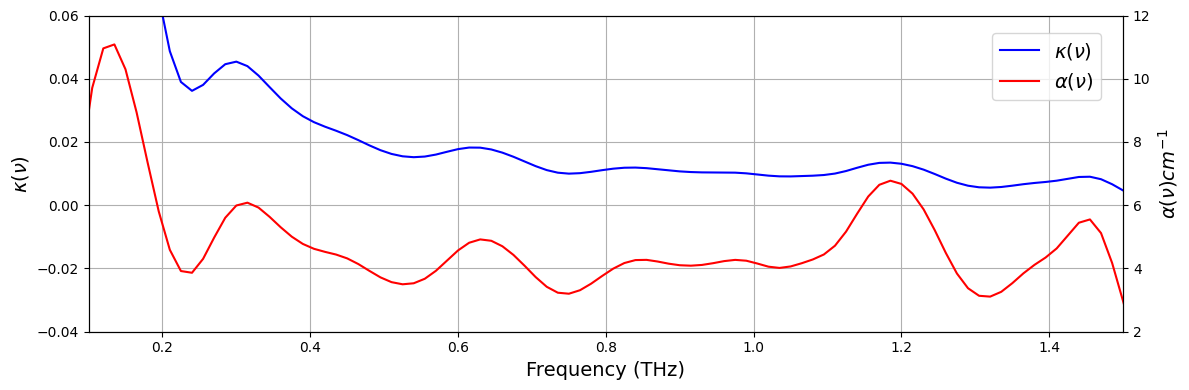

In [63]:
figure, ax = plt.subplots(figsize=(12,4), tight_layout=True)
ax2 = ax.twinx()
ax.plot(freqs[1:max_freq_id]*1e-12, kappa[1:max_freq_id], 'b')
ax2.plot(freqs[1:max_freq_id]*1e-12, alpha[1:max_freq_id]*1e-2, 'r')
ax.set_xlabel('Frequency (THz)', fontsize=14)
ax.set_ylabel(r'$\kappa (\nu)$', fontsize=14)
ax2.set_ylabel(r'$\alpha(\nu) cm^{-1}$', fontsize=14)
ax.set_xlim((.1,1.5))
ax.set_ylim((-.04,.06))
ax2.set_ylim((2,12))
ax.grid()
figure.legend([r'$\kappa(\nu)$', r'$\alpha(\nu)$'], bbox_to_anchor=(.93,.93), fontsize=14)
plt.show()

In [64]:
n_mean = np.mean(n[low_freq_id//2:max_freq_id//2])
kappa_mean = np.mean(kappa[low_freq_id//2:max_freq_id//2])
print(f'n mean: {n_mean: 1.2f} \nkappa mean: {kappa_mean: 1.2f}')

n mean:  3.19 
kappa mean:  0.03


# FFT without zero padding

In [65]:
dict_of_all_dfs_fft = {key_name+"_fft": np.conj(fft(df['X'])) for key_name, df in dict_of_all_dfs.items()}

In [66]:
N = T.shape[0]
N_pos = N // 2
freqs_pos = fftfreq(N, time_step)[low_freq_id:N_pos] # Frequencies between 0.1 THz and 1.5 THz

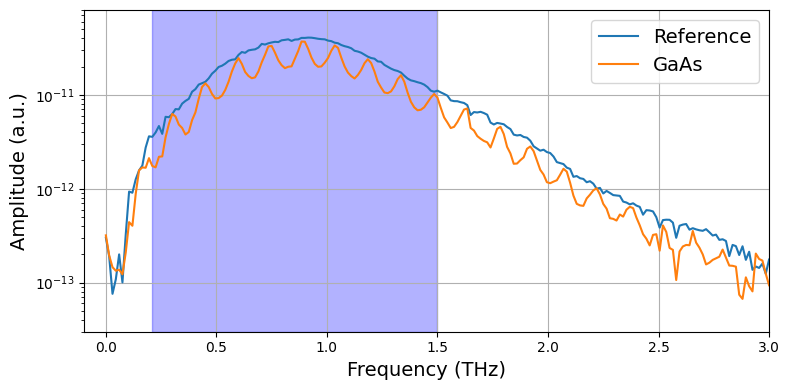

In [79]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
id = 0
for df_name, df in dict_of_all_dfs_fft.items():
    id+=1
    if id%2==0:
        continue
    y = 2.0/N * np.abs(df[:N])
    ax.semilogy(freqs[:max_freq_id]*1e-12, y[:max_freq_id])
# ax.plot([freqs[low_freq_id]*1e-12, freqs[low_freq_id]*1e-12], [3e-14, 8e-11],'r')
# ax.plot([freqs[max_freq_id//2]*1e-12, freqs[max_freq_id//2]*1e-12], [3e-14, 8e-11],'r')
ax.fill_betweenx([3e-14, 8e-11], freqs[low_freq_id]*1e-12, freqs[max_freq_id//2]*1e-12, alpha=0.3, color='blue',)
ax.set_xlabel('Frequency (THz)', fontsize=14)
ax.set_ylabel('Amplitude (a.u.)', fontsize=14)
ax.legend(['Reference', 'GaAs'], fontsize=14)
ax.set_xlim((-.1, 3))
ax.set_ylim((3e-14, 8e-11))
ax.grid()
plt.show()

# Fitting the parameters for the transmission coefficient

As we could saw, the complex refractive index has little variations with frequency, hence a model considering it constant in frequency might be interesting to calculate, and it allow us to consider all reflections, leading us to the expression for the complex transmission coefficient:

$$
\tilde{\mathcal{T}}(\nu, n, \kappa, d) = \frac{4(n + ik)}{(n + i\kappa + 1)^2}e^{2\pi i(n + i\kappa - 1)\nu d / c}\left[ 1 - \left(\frac{n + i\kappa -1}{n + i\kappa + 1}\right)^2 e^{4\pi i (n + i\kappa)\nu d / c} \right]^{-1},
$$
where the term between brackets were calculated using an infinite series calculation for the Fabry-Perot term.

In [68]:
# Complex function
def transmission_complex(f, n, k, d):
    n_complex = n + 1j*k
    term1 = 4 * n_complex / (n_complex + 1)**2
    term_exp1 = np.exp(2 * np.pi * 1j * (n_complex - 1) * f * d / c)
    term_in = (1 - (n_complex - 1) / (n_complex + 1) * np.exp(4 * np.pi * 1j * n_complex * f * d / c))
    return term1 * term_exp1 / term_in

In [69]:
# 2N array, with real and imaginary parts stacked
def fit_wrapper(f_array, n, k, d):
    T_model = transmission_complex(f_array, n, k, d)
    return np.hstack([np.real(T_model), np.imag(T_model)])

In [80]:
N = T.shape[0]
N_pos = N // 2
freqs_pos = fftfreq(N, time_step)[low_freq_id:N_pos] # Frequencies between 0.1 THz and 1.5 THz

In [81]:
T = dict_of_all_dfs_fft['20230928-155856_3mmHole+0.5mmGaAs_fft'] / dict_of_all_dfs_fft['20230928-154719_ref_fft']
T_pos = T[low_freq_id:N_pos]

In [82]:
f_max_id = np.where(freqs_pos < 1.5e12)
freqs_fit = freqs_pos[f_max_id]
T_fit = T_pos[f_max_id]

In [83]:
amplitude = np.abs(T_fit)
phase_unwrapped = np.unwrap(np.angle(T_fit))
T_fit_unwrapped = amplitude * np.exp(1j * phase_unwrapped)
y_data_stacked = np.hstack([np.real(T_fit_unwrapped), np.imag(T_fit_unwrapped)])

In [84]:
p0 = [3.6, 0.02, 0.0005]
params, covariance = curve_fit(fit_wrapper, freqs_fit, y_data_stacked, p0=p0)

print(f"Fitted parameters: n={params[0]:1.3f}, k={params[1]:1.3f}, d={params[2]*1e3:1.4f} mm")

Fitted parameters: n=3.596, k=0.021, d=0.4220 mm


In [85]:
print(np.sqrt(np.abs(covariance)))

[[9.03446111e-03 5.82537357e-04 1.04969671e-04]
 [5.82537357e-04 9.92897055e-04 6.80958575e-06]
 [1.04969671e-04 6.80958575e-06 1.22704445e-06]]


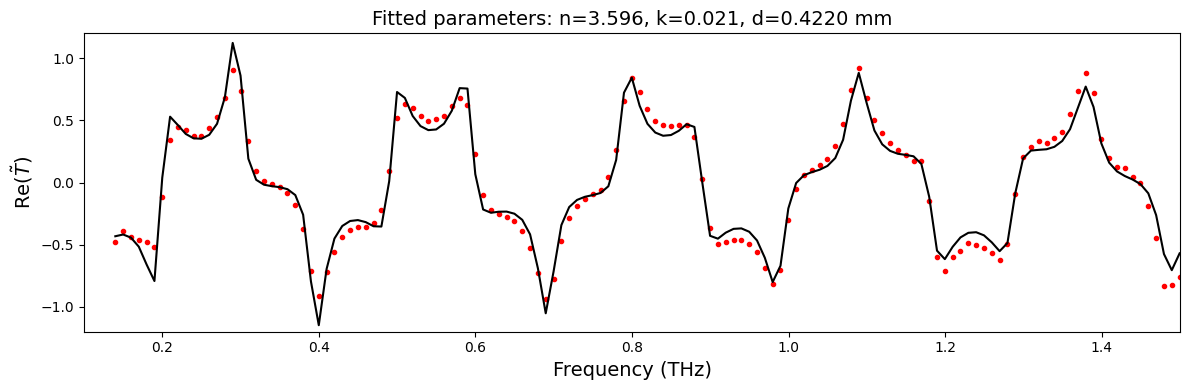

In [86]:
fig, ax = plt.subplots(figsize = (12, 4), tight_layout=True)
ax.plot(freqs_fit*1e-12, np.real(T_fit_unwrapped), 'r.', markersize=6)
ax.plot(freqs_fit*1e-12, np.real(transmission_complex(freqs_fit, *params)), 'k-')
ax.set_xlim((.1, 1.5))
ax.set_ylim((-1.2, 1.2))
ax.set_title(f"Fitted parameters: n={params[0]:1.3f}, k={params[1]:1.3f}, d={params[2]*1e3:1.4f} mm", fontsize=14)
ax.set_xlabel('Frequency (THz)', fontsize=14)
ax.set_ylabel(r'Re$(\tilde{T})$', fontsize=14)

plt.show()

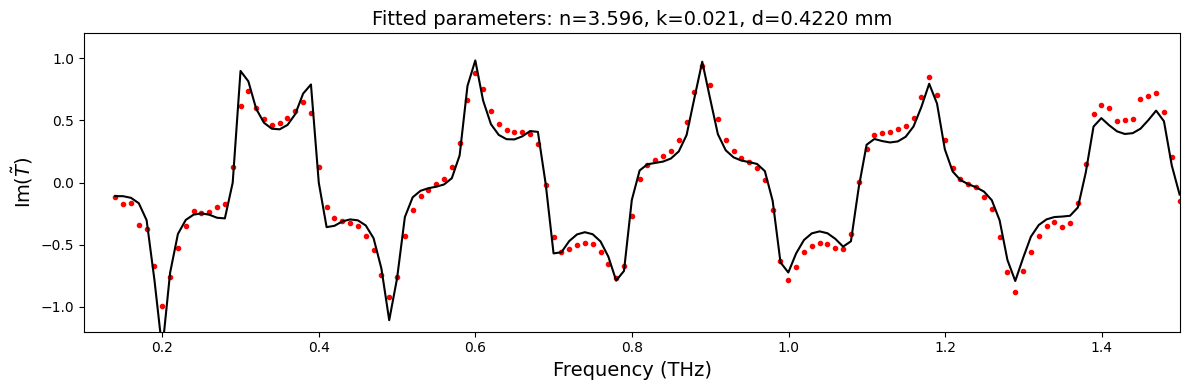

In [87]:
fig, ax = plt.subplots(figsize = (12, 4), tight_layout=True)
ax.plot(freqs_fit*1e-12, np.imag(T_fit_unwrapped), 'r.', markersize=6)
ax.plot(freqs_fit*1e-12, np.imag(transmission_complex(freqs_fit, *params)), 'k-')
ax.set_xlim((.1, 1.5))
ax.set_ylim((-1.2, 1.2))
ax.set_title(f"Fitted parameters: n={params[0]:1.3f}, k={params[1]:1.3f}, d={params[2]*1e3:1.4f} mm", fontsize=14)
ax.set_xlabel('Frequency (THz)', fontsize = 14)
ax.set_ylabel(r'Im$(\tilde{T})$', fontsize=14)

plt.show()